In [5]:
from deepmol.loaders import CSVLoader

dataset = CSVLoader("../../final_dataset_top_v2.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()


2024-03-22 14:27:08,375 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


In [6]:
from deepmol.datasets import SmilesDataset

compounds_to_remove =["C00002147", "C00002193", "C00051791", "C00051789", "C00051782", "C00035340", "C00031117","C00051792", "C00001770", "C00026041",
                      "C00051785", "C00051786", "C00001742", "C00001741", "C00025891", "C00025892"]

columns_to_keep = [1, 17]

dataset_y = dataset.y[:,[i for i in range(0, dataset.y.shape[1]) if i in columns_to_keep]]
# get the rows with at least one non-zero value
rows_to_remove = []
for i in range(0, dataset_y.shape[0]):
    if dataset_y[i,:].sum() != 2:
        rows_to_remove.append(i)

# remove the rows from the dataset.ids and check what there is left
dataset_ids = [dataset.ids[i] for i in range(0, len(dataset.ids)) if i not in rows_to_remove]
dataset_mols = [dataset.mols[i] for i in range(0, len(dataset.mols)) if i not in rows_to_remove]

dataset_mols = [dataset_mols[i] for i in range(0, len(dataset_mols)) if dataset_ids[i] in compounds_to_remove]
dataset_ids = [dataset_ids[i] for i in range(0, len(dataset_ids)) if dataset_ids[i] in compounds_to_remove]
len(dataset_ids) == len(dataset_mols)

True

2024-03-22 14:27:13,256 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


[14:27:13] SMILES Parse Error: syntax error while parsing: [ROH]
[14:27:13] SMILES Parse Error: Failed parsing SMILES '[ROH]' for input: '[ROH]'
[14:27:13] SMILES Parse Error: syntax error while parsing: [ROH]
[14:27:13] SMILES Parse Error: Failed parsing SMILES '[ROH]' for input: '[ROH]'
[14:27:13] SMILES Parse Error: syntax error while parsing: [ROH]
[14:27:13] SMILES Parse Error: Failed parsing SMILES '[ROH]' for input: '[ROH]'
[14:27:13] SMILES Parse Error: syntax error while parsing: [ROH]
[14:27:13] SMILES Parse Error: Failed parsing SMILES '[ROH]' for input: '[ROH]'
[14:27:13] SMILES Parse Error: syntax error while parsing: [ROH]
[14:27:13] SMILES Parse Error: Failed parsing SMILES '[ROH]' for input: '[ROH]'
[14:27:13] SMILES Parse Error: syntax error while parsing: [ROH]
[14:27:13] SMILES Parse Error: Failed parsing SMILES '[ROH]' for input: '[ROH]'
[14:27:13] SMILES Parse Error: syntax error while parsing: [ROH]
[14:27:13] SMILES Parse Error: Failed parsing SMILES '[ROH]' for 

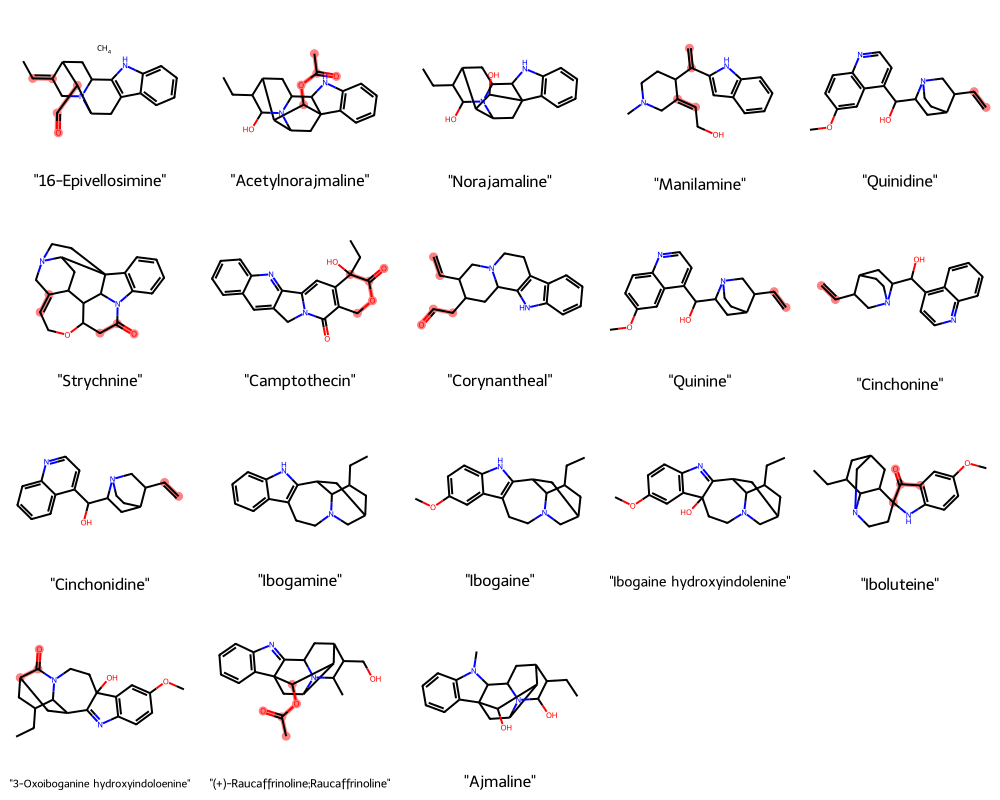

In [7]:
# draw all the molecules using rdkit and contained in dataset.mols
from rdkit import Chem
from rdkit.Chem import MolFromSmarts, MolFromSmiles
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import pandas as pd


dataset = CSVLoader("../../final_dataset_top_v2.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()


columns_to_keep = [1, 17]

dataset_y = dataset.y[:,[i for i in range(0, dataset.y.shape[1]) if i in columns_to_keep]]
# get the rows with at least one non-zero value
rows_to_remove = []
for i in range(0, dataset_y.shape[0]):
    if dataset_y[i,:].sum() != 2:
        rows_to_remove.append(i)

alkaloid_data = pd.read_csv("../results_for_alkaloids_dataset/cv_data/alkaloid_data.csv")

dataset_ids = [dataset.ids[i] for i in range(0, len(dataset.ids)) if i not in rows_to_remove]
dataset_mols = [dataset.mols[i] for i in range(0, len(dataset.mols)) if i not in rows_to_remove]
alkaloid_data = alkaloid_data[alkaloid_data['CID'].isin(dataset_ids)]

for mol in dataset_mols:
    AllChem.Compute2DCoords(mol)

# add name of the molecules to the mols list
for i, mol in enumerate(dataset_mols):
    mol.SetProp("_Name", alkaloid_data[alkaloid_data['CID'] == dataset_ids[i]]['Name'].values[0])

fragments = ["C1COC=CC1", "C=C", "CC=O", "COC=O", "[ROH]"]

atoms_to_highlight = []
molecules_for_training_set = []
ids_for_training_set = []
molecules_for_test_set = []
ids_for_test_set = []
atoms_to_highlight_test_set = []
for i, mol in enumerate(dataset_mols):
    atoms = []
    matches_n = 0
    for fragment in fragments:
        to_match = MolFromSmiles(fragment)
        if to_match is None:
            to_match = MolFromSmarts(fragment)
        matches = mol.GetSubstructMatches(to_match)
        matches_n += len(matches)
        for match in matches:
            for atom in match:
                atoms.append(atom)
    atoms_to_highlight.append(tuple(atoms))
    if matches_n > 2:
        molecules_for_training_set.append(mol)
        ids_for_training_set.append(dataset_ids[i])
    else:
        molecules_for_test_set.append(mol)
        atoms_to_highlight_test_set.append(tuple(atoms))
        ids_for_test_set.append(dataset_ids[i])

# draw the molecules
img = Draw.MolsToGridImage(molecules_for_test_set, molsPerRow=5, subImgSize=(200,200), legends=[mol.GetProp("_Name") for mol in molecules_for_test_set], highlightAtomLists=atoms_to_highlight_test_set)
img

In [8]:
compounds_to_remove = ids_for_test_set
test_dataset_4_compounds = dataset.select(compounds_to_remove)
compounds_to_add_to_test_set = [
                                ("C16728", "Quinidinone", "COC1=CC2=C(C=CN=C2C=C1)C(=O)[C@H]3CC4CCN3C[C@@H]4C=C")]

compounds_to_add_to_test_set = SmilesDataset(smiles= ["COC1=CC2=C(C=CN=C2C=C1)C(=O)[C@H]3CC4CCN3C[C@@H]4C=C"],
              ids=["C16728"], y=test_dataset_4_compounds.y[:1, :])
dataset.remove_elements(compounds_to_remove, inplace=True)
test_dataset_4_compounds = test_dataset_4_compounds.merge([compounds_to_add_to_test_set])

2024-03-22 14:27:17,230 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-22 14:27:17,240 — ERROR — Features are not the same length/type... Recalculate features for all inputs!


In [1]:
from deepmol.pipeline import Pipeline
pipeline_285 = Pipeline.load('../sm_predictor_pipeline_tpe_sklearn/trial_285')

2024-03-22 14:22:27.627808: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 14:22:27.725073: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 14:22:27.725149: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 14:22:27.725212: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-22 14:22:27.741287: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 14:22:27.742092: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

[('standardizer',
  <deepmol.base.transformer.PassThroughTransformer at 0x7fb6c939d240>),
 ('featurizer',
  <deepmol.compound_featurization.rdkit_fingerprints.LayeredFingerprint at 0x7fb4d9b6e890>),
 ('scaler',
  <deepmol.base.transformer.PassThroughTransformer at 0x7fb4d998add0>),
 ('feature_selector',
  <deepmol.feature_selection.base_feature_selector.LowVarianceFS at 0x7fb4d998ae30>),
 ('model',
  SklearnModel(model=RidgeClassifier(alpha=4.424800917505173),
               model_dir='../sm_predictor_pipeline_tpe_sklearn/trial_285/model/model.pkl'))]

In [4]:
pipeline_285.steps[3][1].__dict__

{'param': 0.06280477246163986,
 '_is_fitted': True,
 'feature_selector': VarianceThreshold(threshold=0.06280477246163986),
 'features_to_keep': array([   1,    2,    3, ..., 2045, 2046, 2047])}

In [19]:
quinoline_ring = MolFromSmarts("n1ccc2ccccc2c1")

C00024668
C00001917
C00001819
C00001899
C00001874
0 5


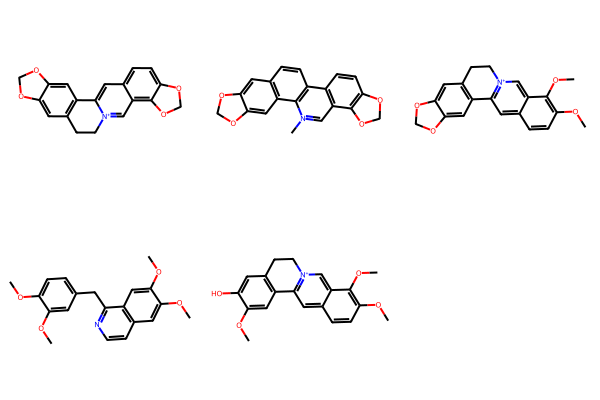

In [24]:
num_matches_with_secologanin = 0
num_matches_without_secologanin = 0
molecules_to_draw = []
for i, mol in enumerate(dataset.mols):
    if mol.GetSubstructMatches(quinoline_ring):
        if dataset.y[i, 17] == 1:
            num_matches_with_secologanin += 1
        elif dataset.y[i, 17] == 0:
            num_matches_without_secologanin += 1
            print(dataset.ids[i])
        molecules_to_draw.append(mol)
print(num_matches_with_secologanin, num_matches_without_secologanin)
Draw.MolsToGridImage(molecules_to_draw)

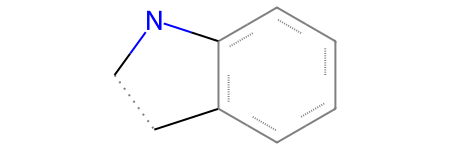

In [43]:
indole_ring = MolFromSmarts("[#6]-1-,=[#6]-c2ccccc2-[#7]-1")
indole_ring

13 59 13


/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


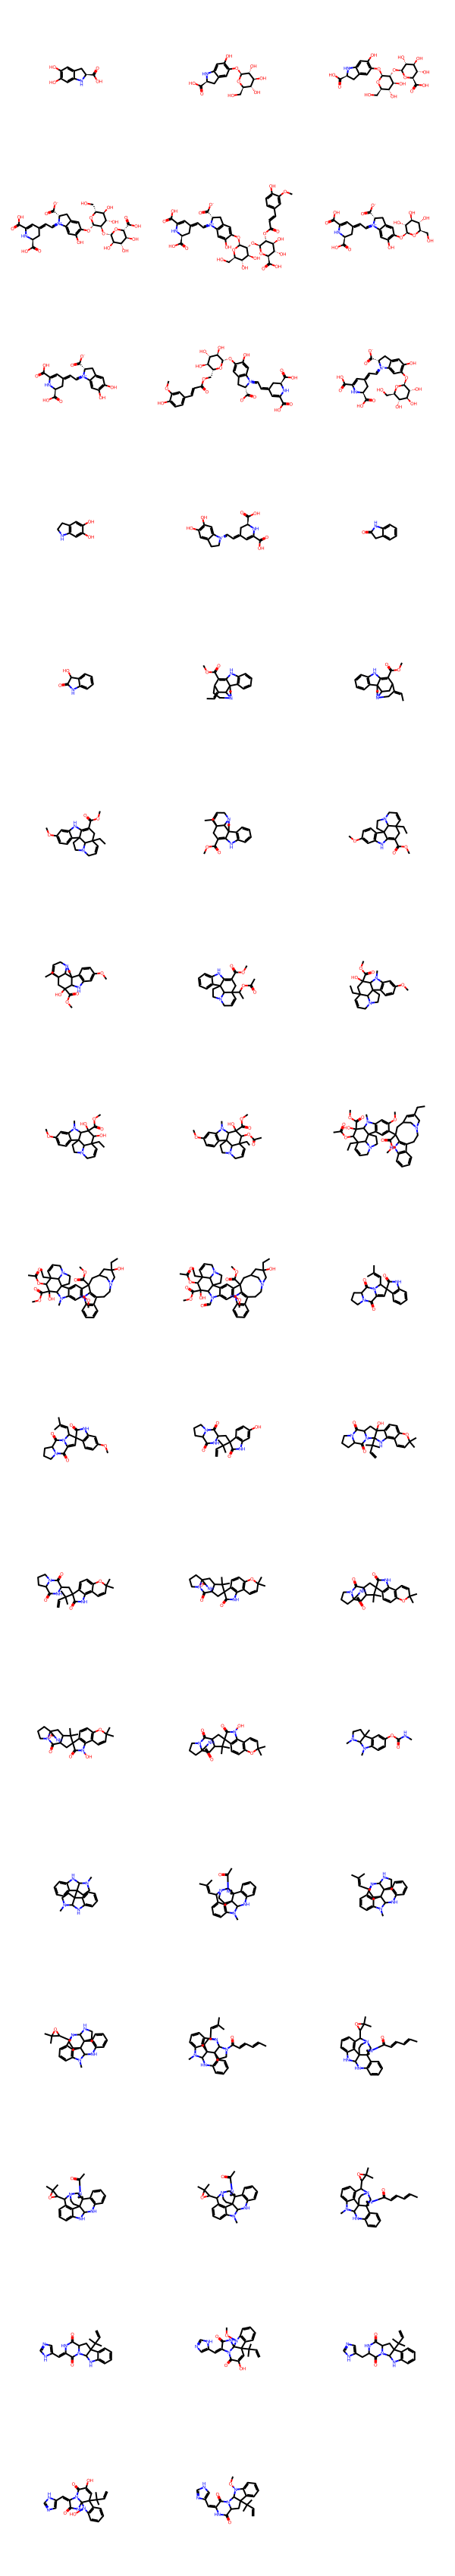

In [48]:
num_matches_with_secologanin = 0
num_matches_without_secologanin = 0
num_matches_tryptophan_and_secologanin = 0
molecules_to_draw = []
for i, mol in enumerate(dataset.mols):
    if mol.GetSubstructMatches(indole_ring):
        if dataset.y[i, 17] == 1:
            num_matches_with_secologanin += 1
            if dataset.y[i, 1] == 1:
                num_matches_tryptophan_and_secologanin += 1
        elif dataset.y[i, 17] == 0:
            num_matches_without_secologanin += 1
        molecules_to_draw.append(mol)
print(num_matches_with_secologanin, num_matches_without_secologanin, num_matches_tryptophan_and_secologanin)
Draw.MolsToGridImage(molecules_to_draw)

In [36]:
from deepmol.pipeline import Pipeline

pipeline_285 = Pipeline.load('../sm_predictor_pipeline_tpe_sklearn/trial_285')
pipeline_285.fit(dataset)
from sklearn.metrics import f1_score, precision_score, recall_score
from deepmol.metrics import Metric

predictions = pipeline_285.predict(test_dataset_4_compounds)
# identify all the columns with only zeros in test_dataset_4_compounds.y (numpy array)
columns_to_remove = []
columns_to_keep = []
for i in range(0, test_dataset_4_compounds.y.shape[1]):
    if test_dataset_4_compounds.y[:,i].sum() == 0:
        columns_to_remove.append(i)
    else:
        columns_to_keep.append(i)
# remove the columns with only zeros from test_dataset_4_compounds.y (numpy array)
y_true = test_dataset_4_compounds.y[:,[i for i in range(0, test_dataset_4_compounds.y.shape[1]) if i not in columns_to_remove]]
predictions = predictions[:,[i for i in range(0, predictions.shape[1]) if i not in columns_to_remove]]

dataset_y = dataset.y[:,[i for i in range(0, dataset.y.shape[1]) if i in columns_to_keep]]
# get the rows with at least one non-zero value
rows_to_remove = []
for i in range(0, dataset_y.shape[0]):
    if dataset_y[i,:].sum() != 2:
        rows_to_remove.append(i)

# remove the rows from the dataset.ids and check what there is left
dataset_ids = [dataset.ids[i] for i in range(0, len(dataset.ids)) if i not in rows_to_remove]
recall_score(y_true[:, 1], predictions[:, 1])

0.7368421052631579

In [37]:
recall_score(y_true[:, 0], predictions[:, 0])

0.8947368421052632

In [38]:
from deepmol.models import SklearnModel
from deepmol.compound_featurization import MorganFingerprint
from sklearn.linear_model import RidgeClassifier

steps = [
         ('morgan fingerprints', MorganFingerprint(radius=2, size=1024, n_jobs=10)),
         ('random forest', SklearnModel(model=RidgeClassifier(random_state=42)))
         ]
pipeline_morgan_fp = Pipeline(steps=steps, path="morgan_fp")
pipeline_morgan_fp.fit(dataset)

In [39]:
predictions = pipeline_morgan_fp.predict(test_dataset_4_compounds)

# identify all the columns with only zeros in test_dataset_4_compounds.y (numpy array)
columns_to_remove = []
columns_to_keep = []
for i in range(0, test_dataset_4_compounds.y.shape[1]):
    if test_dataset_4_compounds.y[:,i].sum() == 0:
        columns_to_remove.append(i)
    else:
        columns_to_keep.append(i)
# remove the columns with only zeros from test_dataset_4_compounds.y (numpy array)
y_true = test_dataset_4_compounds.y[:,[i for i in range(0, test_dataset_4_compounds.y.shape[1]) if i not in columns_to_remove]]
predictions = predictions[:,[i for i in range(0, predictions.shape[1]) if i not in columns_to_remove]]

In [40]:
print(recall_score(y_true[:, 1], predictions[:, 1]))
print()
print(precision_score(y_true[:, 1], predictions[:, 1]))
print()
print(f1_score(y_true[:, 1], predictions[:, 1]))


0.8947368421052632

1.0

0.9444444444444444


In [41]:
transformed_test_dataset = pipeline_morgan_fp.transform(test_dataset_4_compounds)

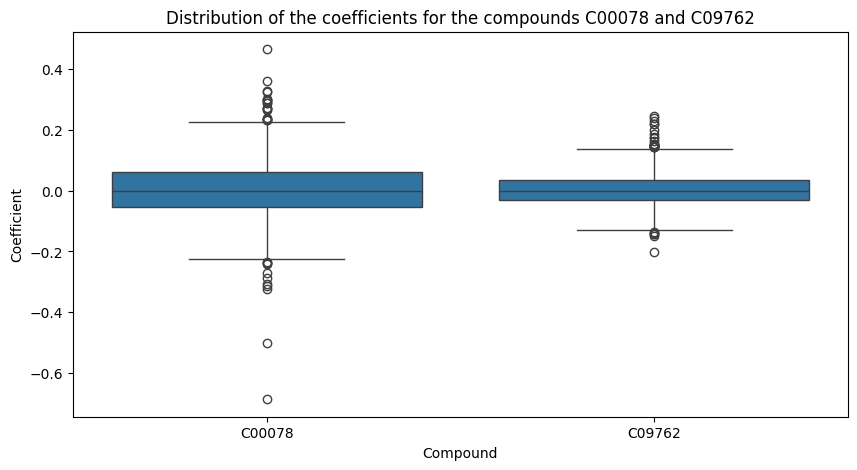

In [42]:
coefs = pipeline_morgan_fp.steps[-1][1].model.coef_
# draw distribution of the coefficients
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

interest_columns = [1, 17]
coefs = coefs[[i for i in range(0, coefs.shape[0]) if i in interest_columns],:]
coefs = coefs.T
coefs = pd.DataFrame(coefs, columns=["C00078", "C09762"])
coefs = coefs.melt()
coefs = coefs.rename(columns={"variable": "Compound", "value": "Coefficient"})
plt.figure(figsize=(10, 5))
sns.boxplot(x="Compound", y="Coefficient", data=coefs)
plt.title("Distribution of the coefficients for the compounds C00078 and C09762")
plt.show()


In [43]:
coefs = pipeline_morgan_fp.steps[-1][1].model.coef_
coefs = coefs[17,:]
# get on bits from the morgan fingerprints
bits = transformed_test_dataset.X[8, :]
on_bits = []
coefs_list = []
for i, bit in enumerate(bits):
    if bit == 1 and coefs[i] > 0.12:
        on_bits.append(i)
        coefs_list.append(coefs[i])

#pd.DataFrame({"bit": on_bits, "coefs": coefs_list}).to_csv("on_bits_molecule_{}/on_bits.csv".format(0), index=False)
print(on_bits)
def draw_bits(on_bits, mol, mol_i):
    from rdkit.Chem import rdMolDescriptors, Mol, rdmolops
    from deepmol.compound_featurization._utils import mol_to_svg,svg_text_to_file
    info = {}
    #best_pipeline.steps[0][1].draw_bit(grape_vine_dataset.mols[molecule], on_bits[2], file_path=f"bit_{bit}.png")
    rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 2,
                                                   1024, bitInfo=info)

    atomsToUse = []
    atoms_ids = []
    highlightAtomColors = {}
    for bit in on_bits:
        aid, rad = info[bit][0]
        env = Chem.FindAtomEnvironmentOfRadiusN(mol, 2, aid)
        atoms_ids.append(aid)
        highlightAtomColors[aid] = (0.3, 0.3, 1)
        for b in env:
            atomsToUse.append(mol.GetBondWithIdx(b).GetBeginAtomIdx())
            atomsToUse.append(mol.GetBondWithIdx(b).GetEndAtomIdx())
    atomsToUse = list(set(atomsToUse))


    depiction = mol_to_svg(mol, molSize=(450, 200), highlightAtoms=atomsToUse, highlightAtomColors=highlightAtomColors)
    svg_text_to_file(depiction.data, f"molecule_{mol_i}.svg")

draw_bits(on_bits, transformed_test_dataset.mols[8], 8)
#pipeline_morgan_fp.steps[0][1].draw_bit(transformed_test_dataset.mols[0], on_bits[0], file_path=f"bit_{bit}.png")

[638, 841, 940]


In [51]:
import os

def draw_bits(on_bits, mol, molecule):
    from rdkit.Chem import rdMolDescriptors, Mol, rdmolops
    from deepmol.compound_featurization._utils import mol_to_svg,svg_text_to_file
    from rdkit import Chem
    from rdkit.Chem import Draw
    info = {}
    #best_pipeline.steps[0][1].draw_bit(grape_vine_dataset.mols[molecule], on_bits[2], file_path=f"bit_{bit}.png")
    rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 2,
                                                   1024, bitInfo=info)
    
    atomsToUse = []
    atoms_ids = []
    highlightAtomColors = {}
    for bit in on_bits:
        aid, rad = info[bit][0]
        env = Chem.FindAtomEnvironmentOfRadiusN(mol, 2, aid)
        atoms_ids.append(aid)
        highlightAtomColors[aid] = (0.3, 0.3, 1)
        for b in env:
            atomsToUse.append(mol.GetBondWithIdx(b).GetBeginAtomIdx())
            atomsToUse.append(mol.GetBondWithIdx(b).GetEndAtomIdx())
    atomsToUse = list(set(atomsToUse))
    drawer = Draw.rdMolDraw2D.MolDraw2DCairo(1000, 700)
    drawer.drawOptions().addAtomIndices = True
    drawer.drawOptions().annotationFontScale = 1
    drawer.drawOptions().setHighlightColour(((0.0, 0.0, 1.0, 0.1)))
    drawer.DrawMolecule(mol, highlightAtoms=atomsToUse, highlightAtomColors=highlightAtomColors)
    drawer.FinishDrawing()
    drawer.WriteDrawingText(f"molecule_{molecule}.png")   


def get_bits(molecule_i, threshold=0.15):
    coefs = pipeline_morgan_fp.steps[-1][1].model.coef_
    coefs = coefs[17,:]
    # get on bits from the morgan fingerprints
    bits = transformed_test_dataset.X[molecule_i, :]
    on_bits = []
    coefs_list = []
    for i, bit in enumerate(bits):
        if bit == 1 and coefs[i] > threshold:
            on_bits.append(i)
            coefs_list.append(coefs[i])
    
    if not os.path.exists("on_bits_molecule_{}".format(molecule_i)):
        os.mkdir("on_bits_molecule_{}".format(molecule_i))
    pd.DataFrame({"bit": on_bits, "coefs": coefs_list}).to_csv("on_bits_molecule_{}/on_bits.csv".format(molecule_i), index=False)
    for bit in on_bits:
        pipeline_morgan_fp.steps[0][1].draw_bit(transformed_test_dataset.mols[molecule_i], bit, file_path=f"on_bits_molecule_{molecule_i}/bit_{bit}.svg")

ids = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12,14,17]
for id_ in ids:
    get_bits(id_, threshold=0.10)
    coefs = pipeline_morgan_fp.steps[-1][1].model.coef_
    coefs = coefs[17,:]
    # get on bits from the morgan fingerprints
    bits = transformed_test_dataset.X[id_, :]
    on_bits = []
    coefs_list = []
    for i, bit in enumerate(bits):
        if bit == 1 and coefs[i] > 0.14:
            on_bits.append(i)
            coefs_list.append(coefs[i])
    draw_bits(on_bits, transformed_test_dataset.mols[id_], id_)

2024-03-20 10:44:46,937 — INFO — Bit 237 with 1 hits!
2024-03-20 10:44:46,954 — INFO — Bit 430 with 1 hits!
2024-03-20 10:44:46,970 — INFO — Bit 584 with 1 hits!


2024-03-20 10:44:47,091 — INFO — Bit 191 with 1 hits!
2024-03-20 10:44:47,107 — INFO — Bit 237 with 1 hits!
2024-03-20 10:44:47,131 — INFO — Bit 584 with 1 hits!
2024-03-20 10:44:47,144 — INFO — Bit 585 with 1 hits!
2024-03-20 10:44:47,158 — INFO — Bit 595 with 1 hits!
2024-03-20 10:44:47,172 — INFO — Bit 638 with 1 hits!
2024-03-20 10:44:47,184 — INFO — Bit 841 with 1 hits!
2024-03-20 10:44:47,193 — INFO — Bit 940 with 1 hits!
2024-03-20 10:44:47,311 — INFO — Bit 316 with 1 hits!
2024-03-20 10:44:47,328 — INFO — Bit 628 with 1 hits!
2024-03-20 10:44:47,349 — INFO — Bit 638 with 1 hits!
2024-03-20 10:44:47,364 — INFO — Bit 922 with 1 hits!
2024-03-20 10:44:47,501 — INFO — Bit 402 with 1 hits!
2024-03-20 10:44:47,520 — INFO — Bit 762 with 1 hits!
2024-03-20 10:44:47,533 — INFO — Bit 922 with 1 hits!
2024-03-20 10:44:47,544 — INFO — Bit 967 with 1 hits!
2024-03-20 10:44:47,661 — INFO — Bit 83 with 1 hits!
2024-03-20 10:44:47,675 — INFO — Bit 277 with 1 hits!
2024-03-20 10:44:47,686 — INF

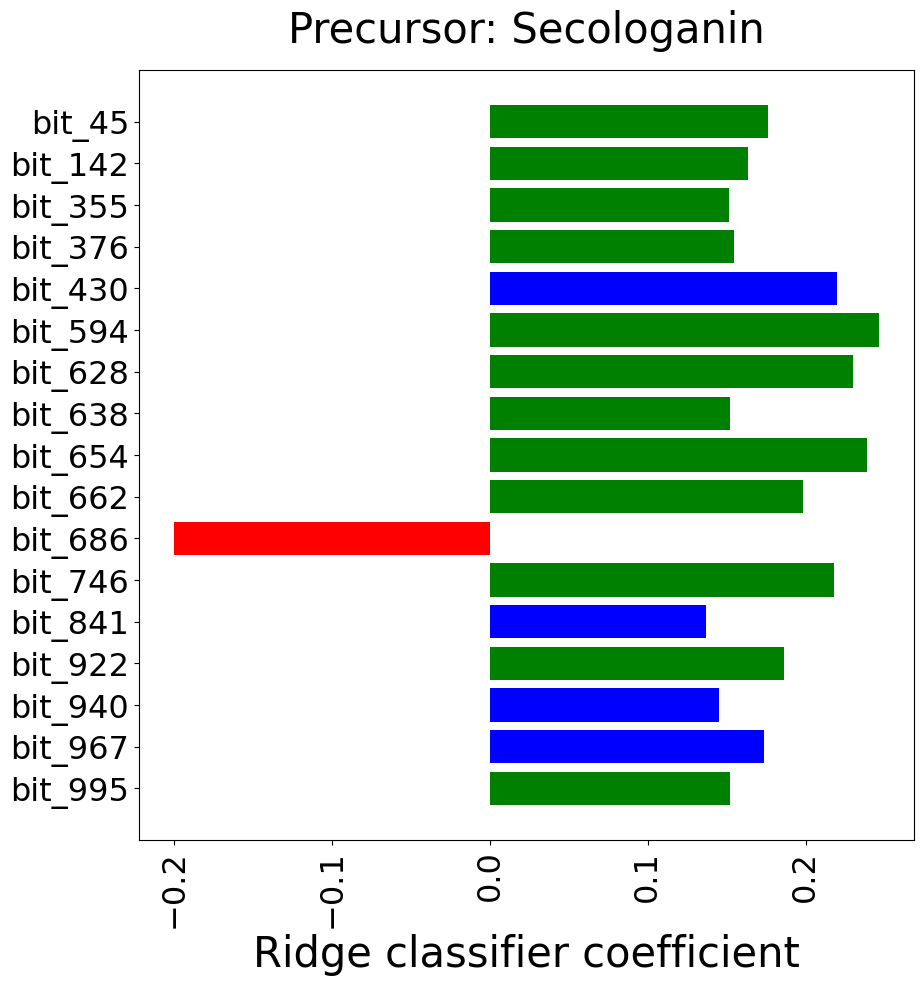

In [70]:
import re


def draw_feature_importance_plot(coefs, on_bits, title="", threshold=0.15):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    coefs = pd.Series(coefs)
    bits = []
    coefs_to_plot = []
    for i, coef in enumerate(coefs):
        if coef >= threshold or coef <= -threshold or i in on_bits:
            bits.append("bit_{}".format(i))
            coefs_to_plot.append(coef)
    plt.figure(figsize=(10, 10))
    sns.barplot(x=coefs_to_plot, y=bits, orient='h')
    plt.xticks(rotation=90)
    # paint bars above 0 with green and below 0 with red
    for i, coef in enumerate(coefs_to_plot):
        if int(re.search("\d+", bits[i]).group()) in on_bits:
            plt.barh(i, coef, color='blue')
        elif coef > 0:
            plt.barh(i, coef, color='green')
        else:
            plt.barh(i, coef, color='red')
    
    plt.title(f"Precursor: {title}", pad =20, fontsize=30)
    plt.xlabel('Ridge classifier coefficient', fontsize=30)
    plt.yticks(fontsize=23)
    plt.xticks(fontsize=23)
    plt.show()

coefs = pipeline_morgan_fp.steps[-1][1].model.coef_
coefs = coefs[17,:]
# get on bits from the morgan fingerprints
bits2 = transformed_test_dataset.X[2, :]
bits4 = transformed_test_dataset.X[-1, :]
on_bits = []
coefs_list = []
for i, bit in enumerate(bits2 + bits4):
    if bit == 1 and coefs[i] > 0.12:
        on_bits.append(i)
        coefs_list.append(coefs[i])
draw_feature_importance_plot(coefs, on_bits, title="Secologanin", threshold=0.15)
